# CookieCutter
This app predicts the total calories given a string of recipe ingredients.

Training data was scraped from AllRecipes.com

Input of web app is a string of recipe ingredents in the following format:
* '2 cups flour; 1 cup sugar; 1/2 cup butter; 1 teaspoon salt'

## Import packages

In [1]:
import numpy as np
import pandas as pd
import re

## Import functions

In [2]:
def multireplace(string, replacements, ignore_case=False):
    """
    Given a string and a replacement map, it returns the replaced string.
    :param str string: string to execute replacements on
    :param dict replacements: replacement dictionary {value to find: value to replace}
    :param bool ignore_case: whether the match should be case insensitive
    :rtype: str
    """
    # If case insensitive, we need to normalize the old string so that later a replacement
    # can be found. For instance with {"HEY": "lol"} we should match and find a replacement for "hey",
    # "HEY", "hEy", etc.
    if ignore_case:
        def normalize_old(s):
            return s.lower()

        re_mode = re.IGNORECASE

    else:
        def normalize_old(s):
            return s

        re_mode = 0

    replacements = {normalize_old(key): val for key, val in replacements.items()}
    
    # Place longer ones first to keep shorter substrings from matching where the longer ones should take place
    # For instance given the replacements {'ab': 'AB', 'abc': 'ABC'} against the string 'hey abc', it should produce
    # 'hey ABC' and not 'hey ABc'
    rep_sorted = sorted(replacements, key=len, reverse=True)
    rep_escaped = map(re.escape, rep_sorted)
    
    # Create a big OR regex that matches any of the substrings to replace
    pattern = re.compile("|".join(rep_escaped), re_mode)
    
    # For each match, look up the new string in the replacements, being the key the normalized old string
    return pattern.sub(lambda match: replacements[normalize_old(match.group(0))], string)

def string_replace(x):
    new_string = re.sub(' {2,}', ' ', x).replace("\n", ";").replace("; ;", ";")
#    new_string = new_string.split(';')
    return(new_string)

def get_ingredients (x):
    ing_regex = ('(\d+/*\d*\s*\d*/*\d*)\s(\w+\s*.*?);')
    all_ing = re.findall(ing_regex, x)
    return(all_ing)

def get_quantity(x):
    quantity = [y[0] for y in x] # use for df
    units_with_ingredient = [y[1] for y in x]
    df_of_units = pd.DataFrame({'quantity':quantity, 'ingredient':units_with_ingredient})
    return (df_of_units)

def match_uids(originaldf, longdf):
    for row in range(0, len(originaldf)):
        longdf[row]['recipe_key']=originaldf['recipe_key'][row]
        longdf[row]['calPerServing']=originaldf['calPerServing'][row]
        longdf[row]['totalCal']=originaldf['totalCal'][row]
        longdf[row]['servings']=originaldf['servings'][row]
        longdf[row]['name']=originaldf['name'][row]
    return(longdf)

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    import string
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    def lemmatize(string):
        for word in re.findall(r"[a-z]+", string):
            string = string.replace(word, wnl.lemmatize(word, 'n') if 's' in word[-3:] else word)
        return string
    
    unit_stopwords = ['dash','pinch','teaspoon','tablespoon','fluid','cup','pint','quart','ounce','oz','pound','rack',
                'small','medium','large','crushed','grated','skinless','boneless','melted','fresh',
                'diced','minced','thinly','dry','dried','halved','taste','frying','lean','drained','jars','grated'
                'clove','slice','eaches','whole','cube','thick','unit','freshly','finely','splash',
                'semisweet','chip','extract','spread','powder','room','temperature','brown','cooking','yolk','ground',
                'package','mix','cake','plain','goody','light','wheat','piece','substitute','mini','kosher','crispy',
                'minature','chunk','dark','bit','square','boiling','bag','crumb','popsicle','stick','zest','cereal',
                'bar','tart','nib','tennessee','turbinado','baking','pack','spice','moist','miniarature','crunchy',
                'morsel','nugget','candy','crisp','super','fine','decoration','sucralose','puree','pureed','rainbow',
                'cut','frozen','broken','round','concentrate','miniature','cooky','virgin','dusting','half','baby',
                'food','jar','seedless','container','box','granule','filling','cold','super','ripe','moisture',
                'packet','instant','mint','ripe','sea','coarse','fun','size','funsize','bulk','chopped','torn',
                'inch','shell','quality','strap','bittersweet','gallon','pure','cane','liquid','drop','hard','yellow'
                'black','strap','kiss','protein','supplement','dessert']
    
    # Remove anything in parenthesis
    mess = re.sub(r"\([^\)]+\)", '', mess)
    # Make everything lowercase
    mess = mess.lower()
    # Remove non-word punctuation
    mess =' '.join(re.findall(r"[-,''\w]+", mess)) # This leaves some commas as a character #
    mess = re.sub(r"\,", ' ', mess)
    # Remove hypenated words
    mess = re.sub(r"(?=\S*['-])([a-zA-Z'-]+)",'',mess) # remove hypenated words
    # Remove punctuation and numbers
    mess = ''.join([i for i in mess if not i.isdigit()])
    # Remove plurals
    mess = lemmatize(mess)
    #clean excess whitespace
    mess = re.sub(r"\s+", ' ', mess).strip()
    # Remove stopwords
    mess = [word for word in mess.split() if word.lower() not in stopwords.words('english')]
    mess  = [word for word in mess if word.lower() not in unit_stopwords]
    mess = ' '.join(mess)
    return(mess.split())

def test_noun(tokens):  
    import nltk
    tagged = nltk.pos_tag(tokens)
    return([token[0] for token in tagged if token[1] in ['NN',]])

def convert_fractions (quantity):
    from fractions import Fraction
    return float(sum(Fraction(s) for s in quantity.split()))

def join_strings(mess):
    # Keep integers
    mess = ' '.join(mess)

    if len(mess)>=1:
        return(mess)
    else:
        return('')

## Clean ingredient text string

In [3]:
# Load data
#df = pd.read_csv('dataset_allrecipes-test-v3_2020-06-02_01-37-25-797.csv') # Dinner recipes
# df = pd.read_csv('dataset_allrecipes-test-v4_choco_chip_cookie_2020-06-06_22-41-30-703.csv') # Chocolate chip recipes

df = pd.read_csv('dataset_allrecipes-test-v4_all-cookies_2020-06-06_22-20-57-219.csv') # all cookie recipes
# df2 = pd.read_csv('dataset_allrecipes-test-v4_all-ingredients_2020-06-06_22-40-04-991.csv') # all ingredient recipes
# df = pd.concat([df,df2]).drop_duplicates() # combine all cookie and ingredient recipes

# Clean column names
df.rename(columns = {'calories':'calPerServing', 'cook':'cookTime', 'prep':'prepTime','ready in':'totalTime'}, inplace = True) 

# Create unique id
df['recipe_key'] = df['url'].apply(lambda x:int(re.findall(r"\d+", x)[0]))

# Calculate total calories per recipe
df['totalCal'] = df['calPerServing']*df['servings']
df = df[(df['servings']<=64) & (df['servings']>=12) & (df['totalCal']<10000)] #filter for recipes with 12-64 servings and < 10,000 total calories
df.reset_index(inplace=True, drop=True)

# Clean ingredient text
dict_unicode = {'\u2009': '', '½':' 1/2', '⅓':'1/3', '⅔':'2/3', '¼':'1/4', '¾':'3/4', '⅕':'1/5', 
                '⅖':'2/5', '⅗':'3/5', '⅘':'4/5', '⅙':'1/6', '⅚':'5/6', '⅐':'1/7', '⅛':'1/8', 
                '⅜':'3/8', '⅝':'5/8', '⅞':'7/8', '⅑':'1/9', '⅒':'1/10'}
df['recipeIngredient'] = [item + ';' for item in df['recipeIngredient']] # add semicolon at end of each string for easier regex filtering
df['recipeIngredient'] = [multireplace(x, dict_unicode) for x in df['recipeIngredient']] # replace unicode characters
df['recipeIngredient'] = [string_replace(x) for x in df['recipeIngredient']] # remove whitespace
ing = [get_ingredients(x) for x in df['recipeIngredient']] # separate ingredients into list of list of tupules of ingredient strings

df_ing = [get_quantity(x) for x in ing] # separate units of measure and ingredients & creates a pandas dataframe for each recipe

clean_df = match_uids(df, df_ing) # pull unique id, calorie (outcome variable), number of servings, and number of ingredients from original dataframe
clean_df = pd.concat(clean_df) # concat list of pandas dataframes into one dataframe
clean_df['quantity'] = [convert_fractions(x) for x in clean_df['quantity']] # convert fractions into integers

# Create multiIndex / hierarchical Dataframe
# clean_df = clean_df.reset_index(drop=True)
clean_df = clean_df.reset_index()


## Normalize quantity of ingredients to grams

In [4]:
# save as csv for web app
# clean_df.to_csv('clean_df.csv')

# Convert measurements to normalized unit  (1 Unit= 1 grams)
clean_df['unit'] = np.where(clean_df.ingredient.str.contains("dash"), .3,
            np.where(clean_df.ingredient.str.contains("pinch"), .6,
            np.where(clean_df.ingredient.str.contains("teaspoon"), 5, 
            np.where(clean_df.ingredient.str.contains("tablespoon"), 3,
            np.where(clean_df.ingredient.str.contains("fluid"), 30,
            np.where(clean_df.ingredient.str.contains("cup"), 240, 
            np.where(clean_df.ingredient.str.contains("pint"), 473,
            np.where(clean_df.ingredient.str.contains("quart"), 980,
            np.where(clean_df.ingredient.str.contains("ounce"), 28,
            np.where(clean_df.ingredient.str.contains("oz"), 28, 
            np.where(clean_df.ingredient.str.contains("pound"), 454,
            np.where(clean_df.ingredient.str.contains("rack"), 908,
            np.where(clean_df.ingredient.str.contains("small"), 50,
            np.where(clean_df.ingredient.str.contains("medium"), 60,
            np.where(clean_df.ingredient.str.contains("large"), 70,
            3))))))))))))))) 

## Tokenize ingredient text

In [5]:
# Tokenization = convert text string into list of tokens, or words, we want (i.e., cleaned version of words).
import string
from nltk.corpus import stopwords
clean_df['ingredient']=[text_process(x) for x in clean_df['ingredient']]

# Total quantity of each ingredient needed for recipe (grams* quantity) and condense into a list.
clean_df['norm_quant'] = round(clean_df['unit']*clean_df['quantity'])
clean_df['norm_quant'] = clean_df['norm_quant'].astype(int)

# One word per ingredient - keep only nouns, join multiple words as one string
clean_df['ingredient'] = [test_noun(tokens) for tokens in clean_df['ingredient']]
clean_df['ingredient'] = [''.join(tokens) for tokens in clean_df['ingredient']]

# Repeat word by normalized quantity
clean_df2 = clean_df.copy()
clean_df2['ingredient'] = clean_df2['ingredient'].astype(str) + ' '
zipped = list(zip(clean_df2['ingredient'], clean_df2['norm_quant']))
inglist = [t[0]*t[1] for t in zipped]
final_df = pd.DataFrame(inglist, columns=['ingredient'])
final_df[['recipe_key','totalCal','calPerServing','name','ingredient_key']] = clean_df[['recipe_key','totalCal','calPerServing','name','index']]

# Create multiIndex / hierarchical Dataframe
tuples = list(zip(*[final_df['recipe_key'],final_df['ingredient_key']]))
index = pd.MultiIndex.from_tuples(tuples, names=['recipe_key', 'ingredient_key'])
final_df.set_index(index,inplace=True)
final_df.head()

ingredient  \
recipe_key ingredient_key                                                      
16212      0               butter butter butter butter butter butter butt...   
           1               sugar sugar sugar sugar sugar sugar sugar suga...   
           2                            water water water water water water    
           3               chocolate chocolate chocolate chocolate chocol...   
           4                                        egg egg egg egg egg egg    

                           recipe_key  totalCal  calPerServing  \
recipe_key ingredient_key                                        
16212      0                    16212    6480.0          162.0   
           1                    16212    6480.0          162.0   
           2                    16212    6480.0          162.0   
           3                    16212    6480.0          162.0   
           4                    16212    6480.0          162.0   

                                                     name  ingredient_key  
recipe_key ingredient_key                                                  
16212      0               Chocolate Mint Candies Cookies               0  
           1               Chocolate Mint Candies Cookies               1  
           2               Chocolate Mint Candies Cookies               2  
           3               Chocolate Mint Candies Cookies               3  
           4               Chocolate Mint Candies Cookies               4

In [6]:
# Test data using ngrams to identify words (ie. baking soda)
from nltk import ngrams

bigram = [list(ngrams(words.lower().split(),2)) for words in clean_df['ingredient']]
# trigram=list(ngrams(Sentences.lower().split(),3))
# fourgram=list(ngrams(Sentences.lower().split(),4))

In [ ]:
df[df['key']==9605]

In [7]:
clean_df.loc[9605]

index                               8
quantity                            1
ingredient                           
recipe_key                      10265
calPerServing                     206
totalCal                         6180
servings                           30
name             Jumbo Raisin Cookies
unit                              240
norm_quant                        240
Name: 9605, dtype: object

## Process input text for App

In [8]:
test = '1 cup packed brown sugar; 2 eggs; 1 teaspoon baking soda; 1 teaspoon salt; 1 teaspoon vanilla extract; 2 1/2 cups sifted all-purpose flour; 1/2 cup chopped walnuts; 2 cups semisweet chocolate chips'
servings = 24
test = test + ';' # add semicolon to end of ingredient list for regex
test = string_replace(test) # remove white space
test_ing = get_ingredients(test) # separate ingredients into list of tuples
testdf = get_quantity(test_ing) # separate quantity from words
testdf['quantity'] = [convert_fractions(x) for x in testdf['quantity']]
testdf['unit'] = np.where(testdf.ingredient.str.contains("dash"), .3,
            np.where(testdf.ingredient.str.contains("pinch"), .6,
            np.where(testdf.ingredient.str.contains("teaspoon"), 5, 
            np.where(testdf.ingredient.str.contains("tablespoon"), 3,
            np.where(testdf.ingredient.str.contains("fluid"), 30,
            np.where(testdf.ingredient.str.contains("cup"), 240, 
            np.where(testdf.ingredient.str.contains("pint"), 473,
            np.where(testdf.ingredient.str.contains("quart"), 980,
            np.where(testdf.ingredient.str.contains("ounce"), 28,
            np.where(testdf.ingredient.str.contains("oz"), 28, 
            np.where(testdf.ingredient.str.contains("pound"), 454,
            np.where(testdf.ingredient.str.contains("rack"), 908,
            np.where(testdf.ingredient.str.contains("small"), 50,
            np.where(testdf.ingredient.str.contains("medium"), 60,
            np.where(testdf.ingredient.str.contains("large"), 70,
            1))))))))))))))) 

# Tokenization = convert text string into list of tokens, or words, we want (i.e., cleaned version of words).
import string
from nltk.corpus import stopwords
testdf['ingredient']=[text_process(x) for x in testdf['ingredient']]

# Total quantity of each ingredient needed for recipe (grams* quantity) and condense into a list.
testdf['norm_quant'] = round(testdf['unit']*testdf['quantity'])
testdf['norm_quant'] = testdf['norm_quant'].astype(int)

# One word per ingredient - keep only nouns, join multiple words as one string
testdf['ingredient'] = [test_noun(tokens) for tokens in testdf['ingredient']]
testdf['ingredient'] = [''.join(tokens) for tokens in testdf['ingredient']]

# Repeat word by normalized quantity
testdf['ingredient'] = testdf['ingredient'].astype(str) + ' '
zipped = list(zip(testdf['ingredient'], testdf['norm_quant']))
inglist = [t[0]*t[1] for t in zipped]
inglist = ''.join(inglist)

In [ ]:
ingredient_bow_inglist = bow_transformer.transform(inglist) # Transform test dataset to Bag of Words
ingredient_bow_inglist

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(ingredient_bow_train,y_train['totalCal'])

predictions = linreg.predict(ingredient_bow_inglist)
predictions

In [ ]:
ingredient_bow_train

# NLP
1) Bag of words

2) TF-IDF (term frequency-inverse document frequency)

3) Combine word weights (from TF-IDF) with quantitative metrics (quantity, serving size), then model based on that

4) Train test split

5) Machine learning model


In [16]:
df.rename(columns = {'recipe_key':'key'}, inplace = True) 
final_df.rename(columns = {'recipe_key':'key'}, inplace = True) 
X_ing = final_df.groupby('recipe_key')['ingredient'].apply(' '.join) # join list of strings into one string per recipe
X_ing = pd.DataFrame(X_ing)
X_ing[['orig_ing','name']] = df.set_index('key')[['recipeIngredient','name']]

y_cal = df.set_index('key')[['totalCal','calPerServing','name']].sort_index().copy()

y_label = df.set_index('key')['totalCal']
X_keys = df.reset_index(drop=True)['key']

from sklearn.model_selection import train_test_split # Train Test Split
key_train, key_test, y_train_label, y_test_label = train_test_split(X_keys, y_label, test_size=0.2, random_state=101) # won't work with multilevel index

X_train = X_ing.loc[key_train]
X_test = X_ing.loc[key_test]
y_train = y_cal.loc[key_train]
y_test = y_cal.loc[key_test]

X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)

X_test.drop([10392, 16571,17337],inplace=True)
y_test.drop([10392, 16571,17337],inplace=True)

print("Training set contains {} recipes in total".format(len(key_train)))
print("Test set contains {} recipes in total".format(len(key_test)))

Training set contains 1836 recipes in total
Test set contains 460 recipes in total


In [251]:
# Save data as csv
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.reset_index().to_csv('y_test.csv')

# NLP - separate steps
#### Bag of words vectorization

In [199]:
from sklearn.feature_extraction.text import CountVectorizer 
bow_transformer = CountVectorizer(analyzer=text_process).fit(X_train['ingredient']) # Bag of Words
print(len(bow_transformer.vocabulary_)) # Print total number of vocab words
print(bow_transformer.get_feature_names()) # Print all words

372
['allspice', 'almond', 'almondbark', 'almondbrickle', 'almondbutter', 'almondflour', 'almondmeal', 'almondmilk', 'almondpaste', 'anise', 'aniseaniseoil', 'aniseoil', 'aniseseed', 'apple', 'applebutter', 'applecinnamongranola', 'applejuice', 'applepeel', 'applepie', 'applesauce', 'apricot', 'apricotfruit', 'apricotjam', 'apricotpreserve', 'avocado', 'bacon', 'bacondice', 'banana', 'bananapudding', 'barley', 'bean', 'berry', 'berrycranberrysauce', 'biscuit', 'biscuitdough', 'blackberry', 'blockchocolate', 'blueberry', 'bourbon', 'bourbonwhiskey', 'bran', 'brandy', 'bread', 'breakfast', 'brownie', 'brownienut', 'butter', 'buttermargarine', 'buttermilk', 'butterscotch', 'butterscotchpudding', 'butterycracker', 'caloriechocolate', 'canolaoil', 'caramel', 'caramelicecreamtopping', 'carawayseed', 'cardamom', 'carob', 'carrot', 'cashew', 'cashewbutter', 'castorsugarsuperfinesugar', 'chaitea', 'cheddarcheese', 'cherry', 'cherrypie', 'cherrypreserve', 'chestnutflour', 'chickpea', 'chocolate'

In [200]:
# Transform data to bag of words

ingredient_bow_train = bow_transformer.transform(X_train['ingredient']) # Transform train dataset to Bag of Words
ingredient_bow_test = bow_transformer.transform(X_test['ingredient']) # Transform test dataset to Bag of Words

# Bag of word counts are saved in a sparse matrix which compresses the information to save computer memory
print('Shape of Sparse Matrix: ', ingredient_bow_train.shape) # matrix size (number of recipes, total number of words)
print('Amount of Non-Zero occurences: ', ingredient_bow_train.nnz) 
sparsity = (100.0 * ingredient_bow_train.nnz / (ingredient_bow_train.shape[0] * ingredient_bow_train.shape[1]))
print('sparsity: {}'.format(sparsity)) # total number of words / (number of recipes * total number of words)*100% compares non-zero words versus total number of words

Shape of Sparse Matrix:  (1836, 372)
Amount of Non-Zero occurences:  13928
sparsity: 2.0392625389462835


In [ ]:
# Sparse matrix[ingredient_name,recipe]
print(ingredient_bow_train[:,1])

In [ ]:
# Example bag of words on one recipe
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
bow0 = bow_transformer.transform([X_train['ingredient'].loc[9611]])
print(bow0) # tells us what words appear and the frequency
print('\n')
print(bow_transformer.get_feature_names()[145]) # This tells us what the word is for a given index

In [ ]:
# Sparse matrix[ingredient_name,recipe]
print(bow_transformer.get_feature_names()[145]) # This tells us what the word is for a given index

#### TF-IDF (term frequency-inverse document frequency)

In [69]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(ingredient_bow_train) # weight of words over whole document

# Example TF-IDF on one recipe
# tfidf0 = tfidf_transformer.transform(bow0)
# print(tfidf0)

# Transform the entire bag-of-words corpus into TF-IDF corpus at once:
ingredient_tfidf_train = tfidf_transformer.transform(ingredient_bow_train)
ingredient_tfidf_test = tfidf_transformer.transform(ingredient_bow_test)
print(ingredient_tfidf_train.shape)
print('\n')
print(ingredient_tfidf_test.shape)

(285, 141)


(72, 141)


In [ ]:
# To see document frequency of a specific word
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['almond']])

### Save ML model using pickle

In [254]:
# Save pickle files
import pickle
pickle.dump(bow_transformer,open('bow_transformer.sav','wb'))
pickle.dump(ingredient_bow_train,open('ingredient_bow_train.sav','wb'))
pickle.dump(ingredient_bow_test,open('ingredient_bow_test.sav','wb'))
pickle.dump(ingredient_tfidf_train,open('ingredient_tfidf_train.sav','wb'))
pickle.dump(ingredient_tfidf_test,open('ingredient_tfidf_test.sav','wb'))

In [13]:
# Load pickle files
import pickle
bow_transformer = pickle.load(open('bow_transformer.sav','rb'))
ingredient_bow_train = pickle.load(open('ingredient_bow_train.sav','rb'))
ingredient_bow_test = pickle.load(open('ingredient_bow_test.sav','rb'))

In [14]:
# Use words idenified only from chocolate chip cookies
import pickle
bow_transformer = pickle.load(open('bow_transformer.sav','rb'))
print(len(bow_transformer.vocabulary_)) # Print total number of vocab words
print(bow_transformer.get_feature_names()) # Print all words

372
['allspice', 'almond', 'almondbark', 'almondbrickle', 'almondbutter', 'almondflour', 'almondmeal', 'almondmilk', 'almondpaste', 'anise', 'aniseaniseoil', 'aniseoil', 'aniseseed', 'apple', 'applebutter', 'applecinnamongranola', 'applejuice', 'applepeel', 'applepie', 'applesauce', 'apricot', 'apricotfruit', 'apricotjam', 'apricotpreserve', 'avocado', 'bacon', 'bacondice', 'banana', 'bananapudding', 'barley', 'bean', 'berry', 'berrycranberrysauce', 'biscuit', 'biscuitdough', 'blackberry', 'blockchocolate', 'blueberry', 'bourbon', 'bourbonwhiskey', 'bran', 'brandy', 'bread', 'breakfast', 'brownie', 'brownienut', 'butter', 'buttermargarine', 'buttermilk', 'butterscotch', 'butterscotchpudding', 'butterycracker', 'caloriechocolate', 'canolaoil', 'caramel', 'caramelicecreamtopping', 'carawayseed', 'cardamom', 'carob', 'carrot', 'cashew', 'cashewbutter', 'castorsugarsuperfinesugar', 'chaitea', 'cheddarcheese', 'cherry', 'cherrypie', 'cherrypreserve', 'chestnutflour', 'chickpea', 'chocolate'

## Remove low variance features
Doesn't remove anything from the sparse matrix (because there are no features that have the same value for all recipes). Need to increase the threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
selector.fit_transform(ingredient_bow_train)

# Linear Regression

### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearRegression(fit_intercept=False)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train['totalCal']) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

### Separate steps
For plotting predicted vs. true values, Linear Regression with fit_intercept=True provies the best results (2X better R2, slope, etc. if fitting intercept vs. not fitting intercept).

In [17]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(ingredient_bow_train,y_train['totalCal'])

predictions = linreg.predict(ingredient_bow_test)
predictions

array([ 6969.44841552,  6235.71996267,  5230.06451307,  2825.21619697,
        4890.20659173,  4825.80312209,  3759.26253189,  4505.19194522,
        4444.59283498,  1991.9913209 ,  5054.19883688,  3102.8420893 ,
        6992.05981251,  4100.62526161,  3767.92608127,  2057.89823653,
        4801.14969224,  5177.70174512,  7457.95848283,  6450.21296424,
        4167.85385665,  4046.08917272,  2798.84325802,  5908.86526694,
        5768.8382498 ,  1965.63647477,  5256.35474354,  1836.1749542 ,
        3984.28875778,  3503.85932703,  6949.17550303,  4052.32445369,
        4355.07822809,  4548.0828302 ,  3598.69582261,  5327.31006355,
        8003.98094569,  3723.72082707,  4516.55887138,  5657.37889961,
        3985.07132142,  5687.19756861,  5001.97174852,  7172.73889415,
        2453.59519207,  5794.27970354,  6293.27831983,  6825.04106051,
        3103.92842301,  2083.40572445,  3371.89926297,  2387.49508155,
        4596.43965759,  5704.06521754,  3170.15199683, -1884.52351533,
      

In [238]:
y_test['predictions'] = predictions
y_test['predictions'].sort_values()

key
10022     -1884.523515
19244       -83.680205
261182      328.077474
143012     1345.009308
10926      1353.269950
              ...     
11585      9559.472850
235468    10711.666848
24455     11609.356553
25035     21571.980029
26203     32351.425726
Name: predictions, Length: 457, dtype: float64

In [18]:
coeff_words = pd.DataFrame(linreg.coef_,bow_transformer.get_feature_names(), columns=['Coeff'])
coeff_words['Coeff'].sort_values(ascending=False)

salt              139.049787
soda               79.087670
anise              73.127486
stevia             48.552825
creamtartar        43.791142
                     ...    
habaneropepper    -52.797806
lime              -53.382475
nutmeg            -65.962131
vodka             -77.647124
cardamom         -134.037792
Name: Coeff, Length: 372, dtype: float64

In [19]:
coeff_words.loc[['sugar','flour','butter','salt','chocolate']]

,Coeff
sugar,2.470375
flour,0.803850
butter,4.474618
salt,139.049787
chocolate,2.967875


In [20]:
from sklearn import metrics
print('MAE:', round(metrics.mean_absolute_error(y_test['totalCal'], predictions),2))
print('MSE:', round(metrics.mean_squared_error(y_test['totalCal'], predictions),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test['totalCal'], predictions)),2))
metrics.r2_score(y_test['totalCal'],predictions) # this r2 is not representative of a normal r2 since it can be negative

MAE: 915.59
MSE: 3713404.35
RMSE: 1927.02


-0.19323064287710223

Text(0, 0.5, 'Predictions')

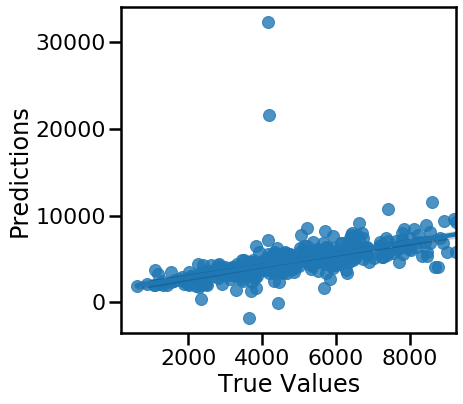

In [21]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster', font_scale=1)

fig = plt.figure(figsize=(6,6))
ax = sns.regplot(y_test['totalCal'],predictions)
# ax.set_title('Linear Regression')
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

In [22]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions,y_test['totalCal'])

print('Slope: ', round(slope,2))
print('Intercept: ', round(intercept))
print('Coefficient of Determinant: ', round(r_value**2,2))
print('p-value: ', p_value)
print('Standard Error: ', round(std_err,2)) # standard error of the slope

Slope:  0.44
Intercept:  2624.0
Coefficient of Determinant:  0.3
p-value:  2.103929944560467e-37
Standard Error:  0.03


#### Residual plot

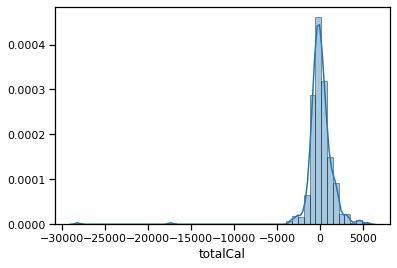

In [23]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.set_context('notebook', font_scale=1)

sns.distplot(y_test['totalCal']-predictions)

#### QQ Plot

((array([-2.96657041e+00, -2.68240836e+00, -2.52245770e+00, -2.40895717e+00,
         -2.31996900e+00, -2.24626665e+00, -2.18306108e+00, -2.12753458e+00,
         -2.07788372e+00, -2.03288197e+00, -1.99165588e+00, -1.95356058e+00,
         -1.91810589e+00, -1.88491019e+00, -1.85367030e+00, -1.82414124e+00,
         -1.79612209e+00, -1.76944597e+00, -1.74397265e+00, -1.71958317e+00,
         -1.69617567e+00, -1.67366226e+00, -1.65196653e+00, -1.63102164e+00,
         -1.61076876e+00, -1.59115583e+00, -1.57213653e+00, -1.55366951e+00,
         -1.53571763e+00, -1.51824746e+00, -1.50122875e+00, -1.48463407e+00,
         -1.46843845e+00, -1.45261909e+00, -1.43715512e+00, -1.42202739e+00,
         -1.40721826e+00, -1.39271147e+00, -1.37849200e+00, -1.36454591e+00,
         -1.35086028e+00, -1.33742308e+00, -1.32422312e+00, -1.31124995e+00,
         -1.29849378e+00, -1.28594548e+00, -1.27359646e+00, -1.26143866e+00,
         -1.24946451e+00, -1.23766688e+00, -1.22603904e+00, -1.21457465e+00,

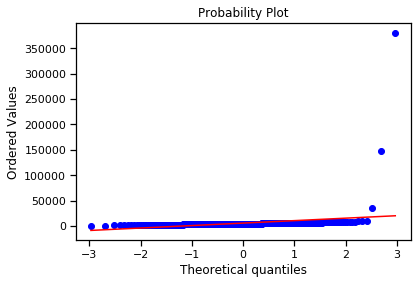

In [107]:
import scipy.stats as stats
stats.probplot(predictions,dist='norm',plot=plt)

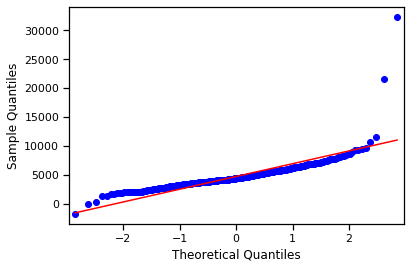

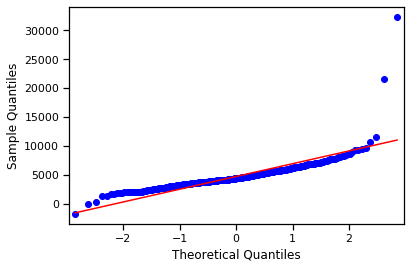

In [209]:
# Using statsmodels
import statsmodels.api as sm
sm.qqplot(predictions, line='s')

### Cross validation and stats using statsmodel is better than sklearn

In [265]:
# Cross validation
from sklearn.model_selection import cross_validate
prediction = cross_validate(linreg,ingredient_bow_test,y_test['totalCal'],cv=10)

# from sklearn.metrics, but r2 is not the same since it can be negative
scoring = ['r2', 'explained_variance','max_error','neg_root_mean_squared_error']
prediction2 = cross_validate(linreg,ingredient_bow_test,y_test['totalCal'],cv=10,scoring=scoring)
prediction2

{'fit_time': array([0.10800409, 0.11256409, 0.10706592, 0.10879779, 0.10790896,
        0.1088419 , 0.10817719, 0.10899019, 0.1081841 , 0.10823178]),
 'score_time': array([0.0008769 , 0.00088096, 0.00084901, 0.00086927, 0.00085521,
        0.00097203, 0.00085473, 0.00086689, 0.00085092, 0.00087237]),
 'test_r2': array([  0.51096005, -25.5543749 ,   0.03028468,   0.54379409,
         -0.14270323,   0.1823052 ,  -0.96148547,  -8.86802058,
        -28.76003071,  -1.4487173 ]),
 'test_explained_variance': array([  0.5206814 , -25.15173442,   0.03855209,   0.55061658,
         -0.11512931,   0.18577331,  -0.95988096,  -8.40181382,
        -26.78879666,  -1.4355707 ]),
 'test_max_error': array([ -4915.11589083, -63687.97330995,  -5847.07508613,  -4373.92887381,
         -7153.77243241,  -3631.74059617, -10448.3356629 , -34287.64711956,
        -42577.22757858, -17293.04529715]),
 'test_neg_root_mean_squared_error': array([ -1338.73420635,  -9465.70808147,  -1692.19774225,  -1122.12614424,
  

### Gradient Boosting Regressor

In [268]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.25
UPPER_ALPHA = 0.75
# Create separate models for lower, median, and upper quantile values
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA)
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA)
# Fit models
lower_model.fit(ingredient_bow_train, y_train['totalCal'])
mid_model.fit(ingredient_bow_train, y_train['totalCal'])
upper_model.fit(ingredient_bow_train, y_train['totalCal'])
# Record actual values on test set
predictions = pd.DataFrame(y_test['totalCal'])
# Predict
predictions['lower'] = lower_model.predict(ingredient_bow_test)
predictions['mid'] = mid_model.predict(ingredient_bow_test)
predictions['upper'] = upper_model.predict(ingredient_bow_test)
predictions['accuracy'] = ((predictions['totalCal'] > predictions['lower']) & ((predictions['totalCal'] < predictions['upper']))).astype(int)
print(round(predictions['accuracy'].mean(),2))
predictions

0.43


,totalCal,lower,mid,upper,accuracy
key,,,,,
9177,8400.0,5377.956969,6263.679904,6479.108795,0
9440,6720.0,5176.491317,5716.773655,5896.973410,0
9471,4880.0,3070.304745,3496.717937,4102.184832,0
9520,2232.0,2704.547501,3234.506009,3857.662853,0
9547,6456.0,4500.084742,5105.875533,5414.945493,0
...,...,...,...,...,...
261182,2352.0,1961.406779,2701.587601,3433.394791,1
266755,5544.0,5513.763722,5716.248245,5906.880236,1
267402,2080.0,2293.054022,3247.244104,3796.319363,0


In [248]:
coeff_words = pd.DataFrame(lower_model.feature_importances_,bow_transformer.get_feature_names(), columns=['coeff_lower'])
coeff_words['coeff_mid'] = mid_model.feature_importances_
coeff_words['coeff_upper'] = upper_model.feature_importances_

In [249]:
len(coeff_words[coeff_words['coeff_mid']==0]) # number of features removed

294

In [236]:
coeff_words['coeff_mid'].sort_values(ascending=False)

sugar                   0.294410
chocolate               0.142786
butter                  0.125321
peanutbutter            0.078691
flour                   0.068212
                          ...   
oatflour                0.000000
oatmeal                 0.000000
orangeblossomwater      0.000000
orangedecoratorsugar    0.000000
allspice                0.000000
Name: coeff_mid, Length: 372, dtype: float64

In [226]:
coeff_words.loc[['sugar','flour','butter','salt','chocolate']]

,coeff_lower,coeff_mid,coeff_upper
sugar,0.202382,0.294410,0.148891
flour,0.087377,0.068212,0.075754
butter,0.155155,0.125321,0.111984
salt,0.022125,0.026466,0.026174
chocolate,0.118789,0.142786,0.102625


Text(0, 0.5, 'Predictions')

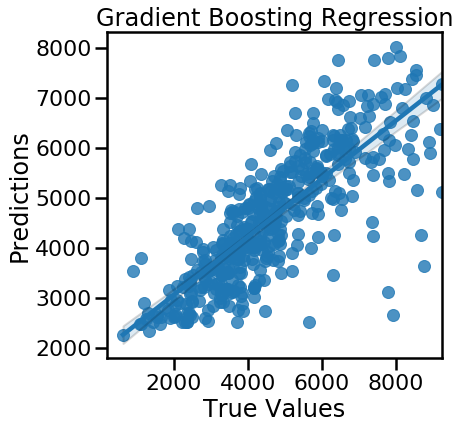

In [269]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster', font_scale=1)

fig = plt.figure(figsize=(6,6))
ax = sns.regplot(y_test['totalCal'],predictions['mid'])
ax.set_title('Gradient Boosting Regression')
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')

In [215]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions['mid'],y_test['totalCal'])

print('Slope: ', round(slope,2))
print('Intercept: ', round(intercept))
print('Coefficient of Determinant: ', round(r_value**2,2))
print('p-value: ', p_value)
print('Standard Error: ', round(std_err,2)) # standard error of the slope

Slope:  1.1
Intercept:  -409.0
Coefficient of Determinant:  0.64
p-value:  1.8747150300183334e-102
Standard Error:  0.04


In [270]:
predictions

,totalCal,lower,mid,upper,accuracy
key,,,,,
9177,8400.0,5377.956969,6263.679904,6479.108795,0
9440,6720.0,5176.491317,5716.773655,5896.973410,0
9471,4880.0,3070.304745,3496.717937,4102.184832,0
9520,2232.0,2704.547501,3234.506009,3857.662853,0
9547,6456.0,4500.084742,5105.875533,5414.945493,0
...,...,...,...,...,...
261182,2352.0,1961.406779,2701.587601,3433.394791,1
266755,5544.0,5513.763722,5716.248245,5906.880236,1
267402,2080.0,2293.054022,3247.244104,3796.319363,0


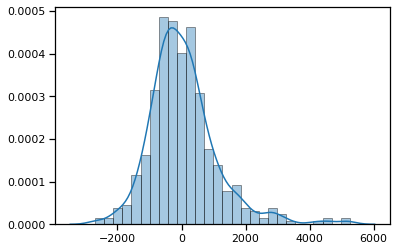

In [216]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.set_context('notebook', font_scale=1)

sns.distplot(y_test['totalCal']-predictions['mid'])

In [273]:
from sklearn import metrics
print('MAE:', round(metrics.mean_absolute_error(y_test['totalCal'], predictions['mid']),2))
print('MSE:', round(metrics.mean_squared_error(y_test['totalCal'], predictions['mid']),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test['totalCal'], predictions['mid'])),2))
metrics.r2_score(y_test['totalCal'],predictions['mid']) # this r2 is not representative of a normal r2 since it can be negative

MAE: 768.47
MSE: 1145862.58
RMSE: 1070.45


0.6317992294029415

In [221]:
# Using statsmodels
import statsmodels.api as sm
sm.qqplot(predictions['mid'], line='s')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Statsmodels linear regression OLS
Doesn't work with BoW datatype. Error message: "Pandas data cast to numpy dtype of object. Check input data with np.asarray(data)."

In [ ]:
# Example on statsmodels OLS webpage
import statsmodels.api as sm
import numpy as np
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
Y = duncan_prestige.data['income']
X = duncan_prestige.data['education']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

In [ ]:
import statsmodels.api as sm
OLSmodel = sm.OLS(y_train['totalCal'],ingredient_bow_train).fit()
predictions = OLSmodel.predict(ingredient_bow_test)
predictions

In [ ]:
sns.pairplot(ingredient_bow_train)

# Data visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # Always plot edges on bar plots using matplotlib

Text(0, 0.5, 'Number of Recipes')

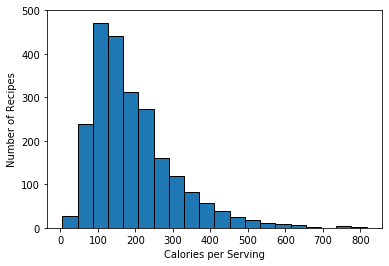

In [12]:
ax = df['calPerServing'].plot(kind='hist',ylim=(0,500),bins=20)
ax.set_xlabel('Calories per Serving')
ax.set_ylabel('Number of Recipes')

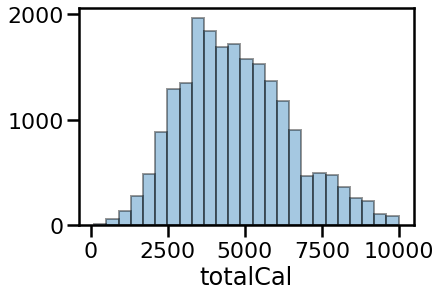

In [183]:
sns.distplot(clean_df['totalCal'],kde=False,bins=25)

In [ ]:
sns.distplot(df['servings'])

In [ ]:
sns.distplot(df['servings'])

In [ ]:
df[df['servings']==60]

In [ ]:
df['servings'].unique()

In [ ]:
sns.regplot(x='servings', y='calPerServing', data=clean_df)

In [ ]:
clean_df.head()

In [ ]:
clean_df['ingredient'].head()

In [ ]:
fig = plt.figure()
word = 'butter'
ax = sns.scatterplot(clean_df[clean_df['ingredient']==word]['norm_quant'],clean_df[clean_df['ingredient']==word]['totalCal'])
ax.set_xlim(0,2000)